data
project_final_clean.html
report
src
0
       IPC  points
0   30.210  30.210
1   30.321  30.321
2   30.349  30.349
3   30.430  30.430
4   30.433  30.433
..     ...     ...
87  62.939  62.939
88  63.380  63.380
89  63.633  63.633
90  64.170  64.170
91  64.787  64.787

[92 rows x 2 columns]


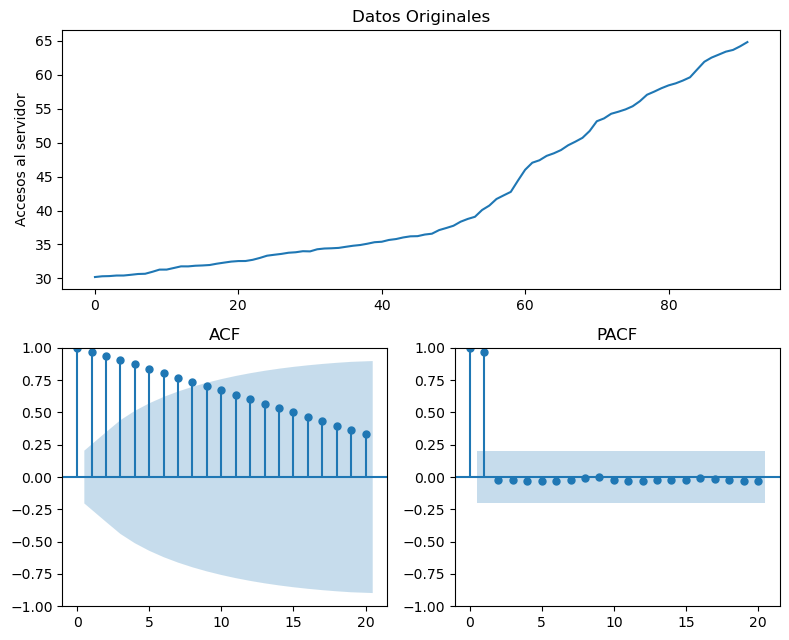

In [2]:
# Importar bibliotecas necesarias para gráficos, manipulación de datos y análisis de series temporales
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Para gráficas de ACF y PACF
import statsmodels.tsa.stattools as st  # Herramientas estadísticas para series temporales

# Variable para alternar entre datos artificiales y datos reales
test_with_artificial = False

# Función para generar datos sintéticos siguiendo un modelo ARIMA
def artificial_arima(p=np.array([]), d=0, q=np.array([]), f=lambda x: x, n=100, m=0):
    """
    Genera datos sintéticos basados en un modelo ARIMA para validar el método en datos reales.

    Parámetros:
    - p: Coeficientes del modelo AR (Autoregresivo).
    - d: Número de diferencias acumulativas para hacer la serie estacionaria.
    - q: Coeficientes del modelo MA (Media Móvil).
    - f: Función de transformación aplicada a los datos generados.
    - n: Número de puntos en la serie temporal.
    - m: Media del ruido blanco agregado.

    Retorna:
    - Serie transformada basada en los parámetros proporcionados.
    """
    a = np.random.normal(0, 1, n)  # Generar ruido blanco con media 0 y varianza 1
    W = np.zeros(n)  # Inicializar la serie temporal

    for t in range(n):
        if t < len(p) or t < len(q):  # Manejar índices fuera de rango
            W[t] = 0
        else:
            # Aplicar componentes AR y MA usando productos escalares
            W[t] = -W[t-len(p):t] @ p[::-1] + a[t] + a[t-len(q):t] @ q[::-1]

    for d_c in range(d):  # Aplicar diferenciación acumulativa d veces
        W = np.cumsum(W)

    W += m  # Agregar media a la serie
    return f(W)  # Aplicar la transformación final

# Si se activa `test_with_artificial`, generar datos sintéticos
if test_with_artificial:
    n = 1000  # Número de puntos en la serie sintética
    points = artificial_arima(
        p=np.array([0]),  # Coeficientes AR
        q=np.array([0]),  # Coeficientes MA
        d=0,  # Diferenciación
        f=np.exp,  # Función de transformación exponencial
        n=n,  # Tamaño de la serie
        m=0  # Media
    )
    # Crear un DataFrame con los datos generados y el índice temporal
    time_series_df = pd.DataFrame({'points': points})
else:
    # Usar un dataset real: WWWusage
    time_series_df = pd.read_csv('../data/IPC.csv')
    
    # Convert the second column to float
    time_series_df = time_series_df.astype({"IPC": float})
    time_series_df["points"] = time_series_df["IPC"]
    
    
    print(time_series_df)
    
# Función para graficar una serie temporal, su ACF y PACF
def plot_series(series, series_title, alpha=0.05):
    """
    Grafica una serie temporal junto con sus funciones ACF y PACF.

    Parámetros:
    - series: Serie temporal a graficar.
    - series_title: Título para la gráfica de la serie temporal.
    - alpha: Nivel de significancia para los intervalos de confianza en ACF y PACF.
    """
    fig = plt.figure(figsize=(8, 6.5))  # Crear figura de tamaño personalizado
    gs = fig.add_gridspec(2, 2)  # Crear un diseño de 2 filas y 2 columnas

    # Gráfica de la serie temporal
    ax0 = fig.add_subplot(gs[0, :])  # Primera fila ocupa ambas columnas
    ax0.plot(series)
    ax0.set_title(series_title)
    ax0.set_ylabel('Accesos al servidor')

    # Gráfica de ACF
    ax1 = fig.add_subplot(gs[1, 0])  # Segunda fila, primera columna
    plot_acf(series, ax=ax1, alpha=alpha)
    ax1.set_title("ACF")

    # Gráfica de PACF
    ax2 = fig.add_subplot(gs[1, 1])  # Segunda fila, segunda columna
    plot_pacf(series, ax=ax2, alpha=alpha)
    ax2.set_title("PACF")

    plt.tight_layout()  # Ajustar diseño
    plt.show()  # Mostrar gráficos

# Graficar la serie temporal con su ACF y PACF
plot_series(time_series_df['points'], "Datos Originales")



Utiliza un método completamente automático de biblioteca para determinar el modelo ARIMA que maximice la precisión, de modo que podamos comparar el resultado de nuestro método con el resultado de este método.

In [3]:
if False:  # Cambia a `True` para ejecutar este bloque de código
    import pmdarima as pm  # Biblioteca para ajuste automático de modelos ARIMA/SARIMA
    
    # Ajustar automáticamente el mejor modelo ARIMA/SARIMA
    model = pm.auto_arima(
        time_series_df['points'],  # Columna de datos de la serie temporal
        seasonal=False,            # Desactiva el componente estacional
        stepwise=False,            # Desactiva el algoritmo de búsqueda paso a paso (más exhaustivo)
        trace=True,                # Muestra detalles del proceso de ajuste
        max_p=3,                   # Máximo valor de p (orden autoregresivo)
        max_q=3,                   # Máximo valor de q (orden de media móvil)
        max_d=2,                   # Máximo número de diferenciaciones (d)
        start_d=2,                 # Comienza probando con una diferenciación inicial d=2
        test='adf',                # Prueba de Dickey-Fuller para verificar estacionariedad
        max_order=10               # Límite máximo para p + q + P + Q
    )
    
    # Mostrar un resumen del mejor modelo ajustado
    print(model.summary())
    
    # Pronosticar valores futuros (por ejemplo, para los próximos 12 períodos)
    forecast = model.predict(n_periods=12)  # Genera predicciones para 12 períodos futuros


Prueba la estacionariedad utilizando el test de raíz unitaria de Dickey-Fuller aumentado.

In [4]:
# Verificar la estacionariedad de la serie temporal
# La hipótesis alternativa de la prueba ADF es que la serie es estacionaria
st.adfuller(time_series_df['points'])  # Realizar la prueba ADF


(2.54902325412832,
 0.9990639726819293,
 1,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 20.0058424285088)

p value > 0.05 => no stationaridad

Aplica la transformación de Box-Cox y usa scipy para estimar el parámetro óptimo de Box-Cox, lambda.

Decidimos no utilizar esta transformación, ya que después de diferenciar los datos, la serie temporal parece bastante estable. Además, obtuvimos mejores resultados al no aplicar ninguna transformación.

Lambda usado:  -1.791403562664271


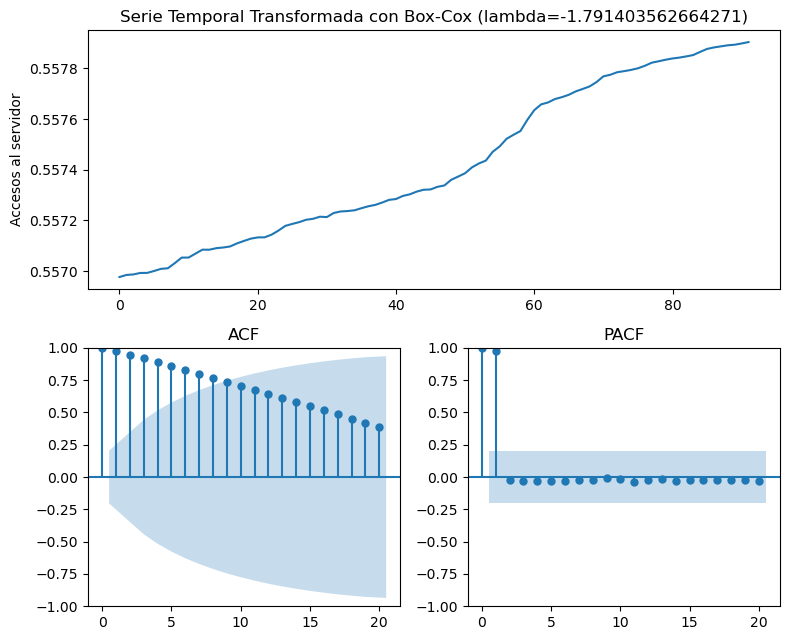

In [5]:
from scipy import stats  # Importar herramientas estadísticas de SciPy

# Variable para controlar si se aplica la transformación Box-Cox
use_trafo = True

# normalizar para hacer la seria numerico stable
normalize = False


# Verificar si se aplica la transformación Box-Cox
if use_trafo:
    # Aplicar la transformación Box-Cox y estimar lambda automáticamente si no se especifica
    lmbda = None  # Valor inicial de lambda; si es None, se estima automáticamente
    if lmbda is None:
        # Aplicar Box-Cox y estimar lambda óptimo
        transformed_prices, lmbda = stats.boxcox(time_series_df["points"])
    else:
        # Aplicar Box-Cox con un valor específico de lambda
        transformed_prices = stats.boxcox(time_series_df["points"], lmbda=lmbda)
    
    # Almacenar los valores transformados en el DataFrame
    time_series_df['T_points'] = transformed_prices
    print("Lambda usado: ", lmbda)  # Mostrar el valor de lambda utilizado
else:
    # Si no se aplica la transformación, conservar la serie original
    lmbda = None
    time_series_df['T_points'] = time_series_df['points']

if normalize:
    norm_fac = np.mean(time_series_df['T_points']**2)**-2
else:
    norm_fac = 1
    
time_series_df['T_points'] = time_series_df['T_points'] * norm_fac 

# Graficar la serie temporal (transformada o sin transformar)
plot_series(time_series_df['T_points'], f"Serie Temporal Transformada con Box-Cox (lambda={lmbda})")


Diferencia los datos hasta que las pruebas de estacionariedad sean positivas.

In [6]:
from statsmodels.sandbox.archive import tsa  # Importar herramientas para análisis de series temporales (opcional)

# Nivel de significancia para la prueba ADF
alpha = 1e-8#0.05  

# Seleccionar la serie transformada sin valores nulos
current_series = time_series_df['T_points'].dropna()
d = 0  # Contador de diferenciaciones aplicadas

# Función para obtener el p-valor de la prueba ADF
def get_adf_p_value(series):
    """
    Realiza la prueba Dickey-Fuller Aumentada (ADF) y retorna el p-valor.

    Parámetros:
    - series: Serie temporal a analizar.

    Retorna:
    - p-valor de la prueba ADF.
    """
    adf_result = st.adfuller(series.dropna())  # Realizar la prueba ADF
    return adf_result[1]  # Retornar el p-valor

# Iterar hasta que la serie sea estacionaria o se alcance el máximo de diferenciaciones
while get_adf_p_value(current_series) >= alpha:
    d += 1  # Incrementar el contador de diferenciaciones
    # Aplicar diferenciación de primer orden
    current_series = current_series.diff()  # Calcula la diferencia entre valores consecutivos

    # Imprimir el progreso y el p-valor después de cada diferenciación
    print(f"Después de {d} diferenciación(es), el p-valor de ADF es: {get_adf_p_value(current_series)}")

# Agregar la serie diferenciada al DataFrame original
time_series_df['diff_points'] = current_series.copy()

# Verificar si la serie es estacionaria después de la diferenciación
if get_adf_p_value(current_series) < alpha:
    print(f"La serie es estacionaria después de {d} diferenciación(es).")
else:
    print("Se alcanzó el máximo de diferenciaciones sin lograr estacionariedad.")



Después de 1 diferenciación(es), el p-valor de ADF es: 9.202930495193036e-07
Después de 2 diferenciación(es), el p-valor de ADF es: 1.93258242481725e-11
La serie es estacionaria después de 2 diferenciación(es).


Grafica la nueva serie temporal y las funciones de ACF y PCF.

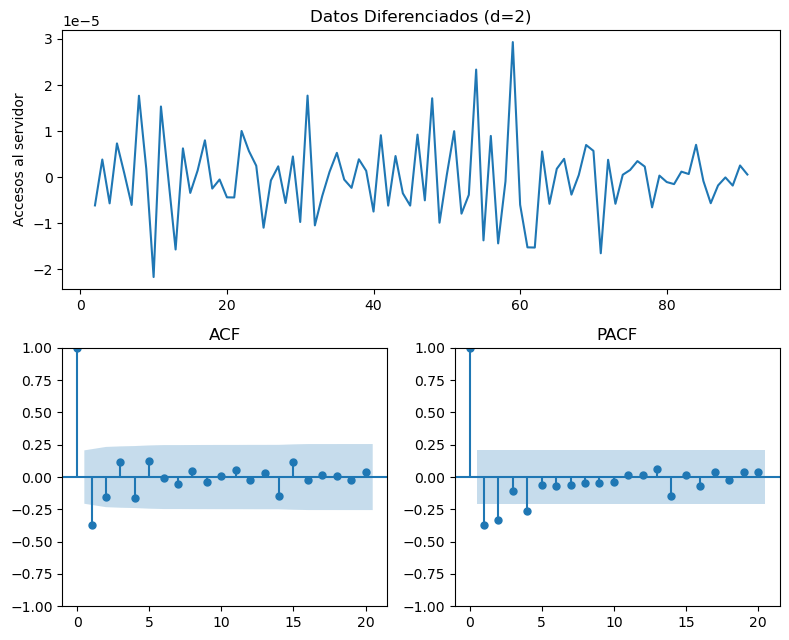

In [7]:
# Seleccionar la serie diferenciada eliminando valores nulos generados por la operación diff
data = time_series_df['diff_points'].dropna()

# Graficar la serie diferenciada junto con las gráficas de ACF y PACF
plot_series(data, f"Datos Diferenciados (d={d})", alpha=0.05)


Imprime todos los rezagos que son significativamente diferentes de cero.

In [8]:
data = time_series_df['T_points'].dropna()

def print_significant_lags(data, alpha=0.05, nlags=26):
    """
    Calculate and print all significantly non-zero lags using ACF.
    
    Parameters:
    -----------
    data : array-like
        The time series data
    alpha : float, default=0.05
        Significance level for the confidence intervals
    nlags : int, default=40
        Number of lags to calculate
    
    Returns:
    --------
    tuple
        - List of significant lag indices
        - ACF values for significant lags
        - Confidence intervals
    """
    # Calculate ACF with confidence intervals
    acf_values, acf_confint = st.acf(data, alpha=alpha, fft=True, nlags=nlags, adjusted=True)
    pacf_values, pacf_confint = st.pacf(data, alpha=alpha, nlags=nlags)
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    acf_significant_lags = []
    acf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | ACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(acf_values)):
        lower_ci = acf_confint[lag][0]
        upper_ci = acf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            acf_significant_lags.append(lag)
            acf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {acf_values[lag]:9.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    pacf_significant_lags = []
    pacf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | PACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(pacf_values)):
        lower_ci = pacf_confint[lag][0]
        upper_ci = pacf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            pacf_significant_lags.append(lag)
            pacf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {pacf_values[lag]:10.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    if not acf_significant_lags and not pacf_significant_lags:
        print("No significant lags found.")
   
    return (acf_significant_lags, acf_significant_values, acf_confint), (pacf_significant_lags, pacf_significant_values, pacf_confint)
sig = print_significant_lags(data)


Significant lags at 5.0% significance level:
----------------------------------------
Lag | ACF Value | Confidence Interval
----------------------------------------
  0 |     1.000 | [ 1.000,  1.000]
  1 |     0.985 | [ 0.780,  1.189]
  2 |     0.968 | [ 0.618,  1.319]
  3 |     0.951 | [ 0.502,  1.399]
  4 |     0.932 | [ 0.406,  1.457]
  5 |     0.911 | [ 0.320,  1.502]
  6 |     0.889 | [ 0.243,  1.536]
  7 |     0.866 | [ 0.171,  1.562]
  8 |     0.843 | [ 0.103,  1.582]
  9 |     0.819 | [ 0.040,  1.597]

Significant lags at 5.0% significance level:
----------------------------------------
Lag | PACF Value | Confidence Interval
----------------------------------------
  0 |      1.000 | [ 1.000,  1.000]
  1 |      0.985 | [ 0.780,  1.189]


## Estimate Parameters


ARIMA(0,2,0):
AIC: -1816.02
BIC: -1813.52

ARIMA(0,2,2):
AIC: -1804.83
BIC: -1797.34


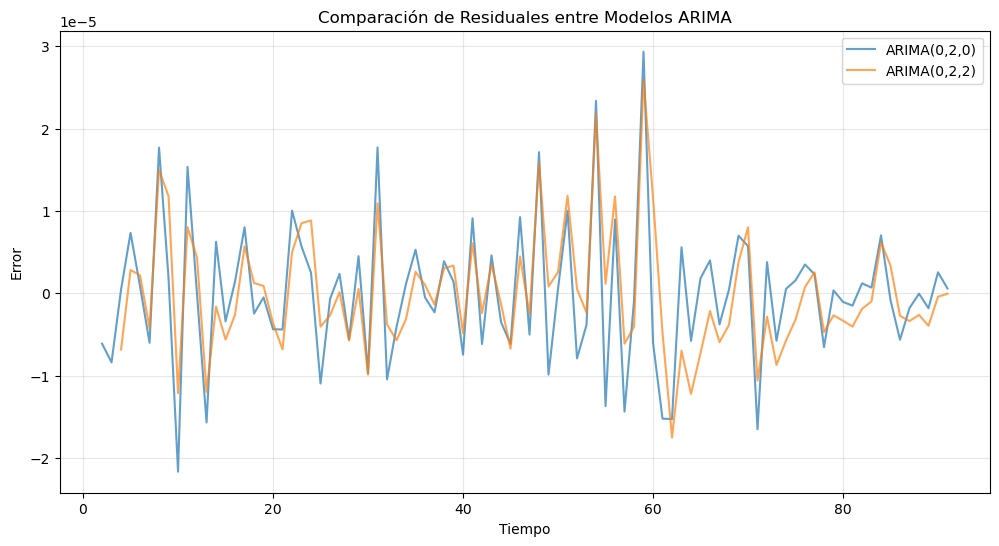

In [9]:
from statsmodels.tsa.arima.model import ARIMA  # Importar el modelo ARIMA

# Seleccionar la serie transformada y eliminar valores nulos
data = time_series_df['T_points'].dropna()

# Definir los modelos ARIMA sugeridos
suggested_models = np.array([
    [0, d, 0],  # Modelo ARIMA(0,d,0)
    [0, d, 2],  # Modelo ARIMA(0,d,2)
])

# Inicializar listas para almacenar resultados y modelos ajustados
results = []  # Lista para almacenar métricas de ajuste (AIC, BIC)
error_dfs = []  # Lista para almacenar los residuales de cada modelo
fitted_models = []  # Lista para almacenar los modelos ajustados

# Iterar sobre los modelos sugeridos y ajustar cada uno
for p, d, q in suggested_models:
    # Ajustar el modelo ARIMA con los parámetros actuales (p, d, q)
    model = ARIMA(data, order=(p, d, q))
    fitted = model.fit()
    
    # Guardar las métricas de rendimiento (AIC y BIC)
    results.append({
        'order': f"ARIMA({p},{d},{q})",
        'aic': fitted.aic,
        'bic': fitted.bic,
        'p': p,
        'd': d,
        'q': q
    })
    
    # Imprimir los resultados del modelo
    print(f"\nARIMA({p},{d},{q}):")
    print(f"AIC: {fitted.aic:.2f}")
    print(f"BIC: {fitted.bic:.2f}")
    
    # Obtener los residuales del modelo ajustado
    residuals = pd.DataFrame(fitted.resid)[p+d+q:]  # Excluir los primeros valores que dependen de datos iniciales
    residuals.columns = [f'ARIMA({p},{d},{q})']  # Etiquetar los residuales con el nombre del modelo
    error_dfs.append(residuals)
    
    # Almacenar el modelo ajustado
    fitted_models.append(fitted)

# Combinar todos los residuales en un único DataFrame
all_errors = pd.concat(error_dfs, axis=1)

# Crear un DataFrame para los modelos ajustados
fitted_models_df = pd.DataFrame({
    'model_order': [f"ARIMA({p},{d},{q})" for p, d, q in suggested_models],
    'fitted_model': fitted_models
})

# Graficar los residuales de los modelos ajustados
plt.figure(figsize=(12, 6))
for column in all_errors.columns:
    plt.plot(all_errors.index, all_errors[column], label=column, alpha=0.7)
plt.legend()
plt.title('Comparación de Residuales entre Modelos ARIMA')
plt.xlabel('Tiempo')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)
plt.show()


## Verify 8 supuestos

### Tests on residuals, Supuestos 1-4


In [10]:
import statsmodels.api as sm  # Importar herramientas para modelos estadísticos
from scipy.stats import shapiro, jarque_bera, ttest_1samp  # Pruebas de normalidad y t-test
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox  # Pruebas de homocedasticidad e independencia

# Inicializar una lista para almacenar los resultados de las pruebas de residuales
residuals_tests = []

# Función para evaluar los residuales de un modelo
def test_residuals(residuals, model_name, alpha=0.05):
    """
    Realiza pruebas estadísticas en los residuales de un modelo y guarda los resultados.

    Parámetros:
    -----------
    residuals : array-like
        Residuales del modelo a evaluar.
    model_name : str
        Nombre del modelo para etiquetar los resultados.
    alpha : float, opcional
        Nivel de significancia para las pruebas (por defecto 0.05).
    """
    results = {}

    # 1. Prueba de media cercana a 0 (t-test)
    p_value = ttest_1samp(residuals, 0).pvalue
    results['mean_close_to_0'] = p_value > alpha  # La media está cerca de 0 si p-valor > alpha
    print(f"{model_name}: Media de residuales = {np.mean(residuals):.4f}, p-valor = {p_value:.4f}")

    # 2. Prueba de varianza constante (homocedasticidad) usando Breusch-Pagan
    _, pvalue, _, _ = het_breuschpagan(residuals, sm.add_constant(np.arange(len(residuals))))
    results['constant_variance'] = pvalue > alpha  # Pasa si p-valor > alpha
    print(f"{model_name}: Homocedasticidad (p-valor de Breusch-Pagan) = {pvalue:.4f}")

    # 3. Pruebas de normalidad (Shapiro-Wilk y Jarque-Bera)
    _, shapiro_pvalue = shapiro(residuals)  # Prueba Shapiro-Wilk
    jb_stat, jb_pvalue = jarque_bera(residuals)  # Prueba Jarque-Bera
    results['normal_distribution'] = shapiro_pvalue > alpha and jb_pvalue > alpha  # Ambas deben pasar
    print(f"{model_name}: Normalidad (p-valor Shapiro-Wilk) = {shapiro_pvalue:.4f}")
    print(f"{model_name}: Normalidad (p-valor Jarque-Bera) = {jb_pvalue:.4f}")

    # 4. Prueba de independencia usando Ljung-Box
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    pvalue_ljungbox = lb_test['lb_pvalue'].values[0]
    results['independent_errors'] = pvalue_ljungbox > alpha  # Pasa si p-valor > alpha
    print(f"{model_name}: Independencia (p-valor de Ljung-Box) = {pvalue_ljungbox:.4f}")

    # Guardar los resultados en la lista
    residuals_tests.append({'model': model_name, 'results': results})

    print("-" * 40)


# Iterar sobre cada columna en el DataFrame `all_errors` (que contiene los residuales de los modelos)
for column in all_errors.columns:
    print(f"Analizando modelo: {column}")
    residuals = all_errors[column].dropna()  # Eliminar valores NaN si existen
    test_residuals(residuals, column)  # Aplicar las pruebas a los residuales


# Resumen de los resultados de las pruebas de residuales
print("\nResumen de las Pruebas de Suposiciones de Residuales:")
for result in residuals_tests:
    model_name = result['model']
    tests = result['results']
    print(f"{model_name}:")
    print(f"  Media cercana a 0: {'Pasa' if tests['mean_close_to_0'] else 'No pasa'}")
    print(f"  Varianza constante: {'Pasa' if tests['constant_variance'] else 'No pasa'}")
    print(f"  Distribución normal: {'Pasa' if tests['normal_distribution'] else 'No pasa'}")
    print(f"  Errores independientes: {'Pasa' if tests['independent_errors'] else 'No pasa'}")
    print("-" * 40)

Analizando modelo: ARIMA(0,2,0)
ARIMA(0,2,0): Media de residuales = -0.0000, p-valor = 0.9140
ARIMA(0,2,0): Homocedasticidad (p-valor de Breusch-Pagan) = 0.3543
ARIMA(0,2,0): Normalidad (p-valor Shapiro-Wilk) = 0.0266
ARIMA(0,2,0): Normalidad (p-valor Jarque-Bera) = 0.0044
ARIMA(0,2,0): Independencia (p-valor de Ljung-Box) = 0.0486
----------------------------------------
Analizando modelo: ARIMA(0,2,2)
ARIMA(0,2,2): Media de residuales = -0.0000, p-valor = 0.9323
ARIMA(0,2,2): Homocedasticidad (p-valor de Breusch-Pagan) = 0.7480
ARIMA(0,2,2): Normalidad (p-valor Shapiro-Wilk) = 0.0014
ARIMA(0,2,2): Normalidad (p-valor Jarque-Bera) = 0.0000
ARIMA(0,2,2): Independencia (p-valor de Ljung-Box) = 0.9800
----------------------------------------

Resumen de las Pruebas de Suposiciones de Residuales:
ARIMA(0,2,0):
  Media cercana a 0: Pasa
  Varianza constante: Pasa
  Distribución normal: No pasa
  Errores independientes: No pasa
----------------------------------------
ARIMA(0,2,2):
  Media 

### Supuesto 5: Modelo Parsimonioso

In [11]:
# Inicializar listas para almacenar modelos que aprueban o fallan la prueba de significancia
models_pass = []  # Modelos cuyos intervalos de confianza NO contienen cero
models_fail = []  # Modelos cuyos intervalos de confianza contienen cero

# Iterar sobre cada modelo ajustado en el DataFrame `fitted_models_df`
for index, row in fitted_models_df.iterrows():
    # Obtener el orden del modelo y el objeto del modelo ajustado
    model_order = row['model_order']
    fitted_model = row['fitted_model']
    
    # Obtener los intervalos de confianza para los parámetros del modelo
    conf_intervals = fitted_model.conf_int()
    parameters = fitted_model.params  # Obtener los valores estimados de los parámetros
    
    # Imprimir los parámetros del modelo
    print(f"\nParámetros para {model_order}:")
    print(parameters)
    
    # Imprimir los intervalos de confianza de los parámetros
    print(f"\nIntervalos de Confianza para {model_order}:")
    print(conf_intervals)
    print("-" * 50)
    
    # Verificar si los intervalos de confianza NO contienen cero
    intervals_do_not_contain_zero = (conf_intervals[0] > 0) | (conf_intervals[1] < 0)
    
    if intervals_do_not_contain_zero.all():
        # Si TODOS los intervalos de confianza no contienen cero
        models_pass.append(model_order)
    else:
        # Si ALGÚN intervalo de confianza contiene cero
        models_fail.append(model_order)

# Imprimir el resumen de resultados
print("\nResumen de Significancia de Parámetros de Modelos ARIMA Basado en Intervalos de Confianza:")
print("===================================================")
print("Modelos que Aprobaron (Intervalos de Confianza NO contienen cero):")
print(models_pass)
print("\nModelos que Fallaron (Intervalos de Confianza contienen cero):")
print(models_fail)


Parámetros para ARIMA(0,2,0):
sigma2    4.974270e-11
dtype: float64

Intervalos de Confianza para ARIMA(0,2,0):
                   0             1
sigma2 -3.629622e-10  4.624476e-10
--------------------------------------------------

Parámetros para ARIMA(0,2,2):
ma.L1    -5.685398e-01
ma.L2    -2.140524e-01
sigma2    1.000000e-10
dtype: float64

Intervalos de Confianza para ARIMA(0,2,2):
                   0             1
ma.L1  -5.685398e-01 -5.685398e-01
ma.L2  -2.140524e-01 -2.140524e-01
sigma2 -3.302066e-10  5.302066e-10
--------------------------------------------------

Resumen de Significancia de Parámetros de Modelos ARIMA Basado en Intervalos de Confianza:
Modelos que Aprobaron (Intervalos de Confianza NO contienen cero):
[]

Modelos que Fallaron (Intervalos de Confianza contienen cero):
['ARIMA(0,2,0)', 'ARIMA(0,2,2)']


### Supuesto 6, modelos crean seria estationario y invertible

In [12]:
# Inicializar listas para almacenar los modelos que pasan o fallan la prueba de estacionariedad
admisible_models = []  # Modelos que cumplen con raíces fuera del círculo unitario
non_admisible_models = []  # Modelos que no cumplen con raíces fuera del círculo unitario

# Iterar sobre cada modelo ajustado en el DataFrame `fitted_models_df`
for index, row in fitted_models_df.iterrows():
    # Obtener el orden del modelo y el objeto del modelo ajustado
    model_order = row['model_order']
    fitted_model = row['fitted_model']
    
    # Obtener los parámetros MA (Media Móvil) del modelo
    ma_params = [param for param in fitted_model.params.index if 'ma.L' in param]
    ma_coefficients = [fitted_model.params[param] for param in ma_params]  # Extraer los valores de los coeficientes MA
    
    # Calcular las raíces del polinomio MA: 1 - p1*x - p2*x^2 - ...
    ma_roots = np.roots(([1] + [-coeff for coeff in ma_coefficients])[::-1])  # Negar los coeficientes para el cálculo
    
    # Obtener los parámetros AR (Autoregresivo) del modelo
    ar_params = [param for param in fitted_model.params.index if 'ar.L' in param]
    ar_coefficients = [fitted_model.params[param] for param in ar_params]  # Extraer los valores de los coeficientes AR
    
    # Calcular las raíces del polinomio AR: 1 - p1*x - p2*x^2 - ...
    ar_roots = np.roots(([1] + [-coeff for coeff in ar_coefficients])[::-1])  # Negar los coeficientes para el cálculo
    
    # Verificar si todas las raíces están fuera del círculo unitario (valor absoluto > 1)
    if np.all(np.abs(ma_roots) > 1) and np.all(np.abs(ar_roots) > 1):
        admisible_models.append(model_order)  # Agregar el modelo a la lista de modelos admisibles
    else:
        non_admisible_models.append(model_order)  # Agregar el modelo a la lista de modelos no admisibles

# Imprimir los resultados de la prueba
print("\nResumen de la Prueba de Admisibilidad Basada en Raíces de los Polinomios MA y AR:")
print("===================================================")
print("Modelos que Pasaron (Modelos Admisibles con Raíces Fuera del Círculo Unitario):")
print(admisible_models)
print("\nModelos que Fallaron (Modelos No Admisibles con Raíces Dentro o en el Círculo Unitario):")
print(non_admisible_models)


Resumen de la Prueba de Admisibilidad Basada en Raíces de los Polinomios MA y AR:
Modelos que Pasaron (Modelos Admisibles con Raíces Fuera del Círculo Unitario):
['ARIMA(0,2,0)', 'ARIMA(0,2,2)']

Modelos que Fallaron (Modelos No Admisibles con Raíces Dentro o en el Círculo Unitario):
[]


### Supuesto 7, 
verifica si las correlaciones entre los parámetros estimados son pequeñas.


In [13]:
from statsmodels.stats.moment_helpers import cov2corr  # Importar función para convertir matriz de covarianza a correlación

# Iterar sobre cada modelo ARIMA en el DataFrame `fitted_models_df`
for idx, row in fitted_models_df.iterrows():
    model_name = row['model_order']  # Nombre del modelo (orden ARIMA)
    fitted_model = row['fitted_model']  # Objeto del modelo ajustado
    
    # Extraer la matriz de varianza-covarianza de los parámetros estimados
    cov_matrix = fitted_model.cov_params()  # Matriz de covarianza de los parámetros
    
    # Convertir la matriz de covarianza a una matriz de correlación
    correlation_matrix = cov2corr(cov_matrix)
    
    # Crear un DataFrame para hacer la matriz de correlación más legible
    correlation_df = pd.DataFrame(correlation_matrix, 
                                  index=fitted_model.param_names,  # Usar nombres de parámetros como índices
                                  columns=fitted_model.param_names)  # Usar nombres de parámetros como columnas
    
    # Mostrar la matriz de correlación
    print(f"\nMatriz de Correlación de Parámetros para {model_name}:")
    print(correlation_df)


Matriz de Correlación de Parámetros para ARIMA(0,2,0):
        sigma2
sigma2     1.0

Matriz de Correlación de Parámetros para ARIMA(0,2,2):
        ma.L1  ma.L2  sigma2
ma.L1     1.0    1.0    -1.0
ma.L2     1.0    1.0    -1.0
sigma2   -1.0   -1.0     1.0


### Supuesto 8
Verificar si los valores atípicos tienen influencia en el resultado. No es necesario ya que no tenemos valores atípicos.

## Calcular la previsión y los intervalos de confianza

Tomamos el modelo ARIMA(2,2,0) para la predicción, ya que es el único que pasó los 8 supuestos (también tuvo correlaciones pequeñas entre los coeficientes).


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import special

# Definir el nivel de confianza para los intervalos
confidence_level = 0.95  # Nivel de confianza del 95%

# Lista de modelos que se usarán para los pronósticos
models_to_forecast = [f'ARIMA(0,{d},2)', f'ARIMA(0,{d},0)']

def forecast(data, models_to_forecast, start, end, lmbda=None, norm_fac=1):
    """
    Realiza pronósticos para los modelos especificados y compara con los datos originales.

    Parámetros:
    -----------
    data : pandas.Series
        Serie temporal original.
    models_to_forecast : list
        Lista de nombres de los modelos ARIMA que se utilizarán para el pronóstico.
    start : int
        Índice inicial del período de pronóstico.
    end : int
        Índice final del período de pronóstico.
    lmbda : float, opcional
        Parámetro de transformación Box-Cox (None si no se aplica).

    Retorno:
    --------
    None. Imprime resultados y genera gráficos.
    """
    forecast_results = {}  # Diccionario para almacenar los resultados de los pronósticos
    
    # Recuperar los datos originales para graficar
    data_to_plot = data[start - (end - start) * 2:]  # Incluye un período adicional para contexto
    
    
    # Iterar sobre cada modelo para realizar pronósticos
    for model_name in models_to_forecast:
        # Obtener el modelo ajustado del DataFrame
        fitted_model = fitted_models_df.loc[fitted_models_df['model_order'] == model_name, 'fitted_model'].iloc[0]
        
        # Realizar pronósticos
        forecast = fitted_model.get_prediction(start=start, end=end) 
        forecast_mean = forecast.predicted_mean.apply(lambda x: x * norm_fac**-1) # Valores pronosticados
        forecast_ci = forecast.conf_int(alpha=1 - confidence_level).apply(lambda x: x * norm_fac**-1)  # Intervalos de confianza ajustados
        
        # Aplicar la transformación inversa de Box-Cox si corresponde
        if lmbda is not None:
            
            forecast_mean = special.inv_boxcox(forecast_mean, lmbda) 
            
            
            forecast_ci['lower T_points'] = forecast_ci['lower T_points'].apply(lambda x: special.inv_boxcox(x, lmbda))
            forecast_ci['upper T_points'] = forecast_ci['upper T_points'].apply(lambda x: special.inv_boxcox(x, lmbda))
        
        # Almacenar los resultados del pronóstico
        forecast_results[model_name] = {'forecast_mean': forecast_mean, 'forecast_ci': forecast_ci}
        
        # Imprimir los resultados del pronóstico
        print(f"\nPronóstico para {model_name} para los próximos {end - start} períodos con Intervalo de Confianza del {confidence_level * 100:.1f}%:")
        print(forecast_mean)
        print("\nIntervalos de Confianza:")
        print(forecast_ci)
        
        # Comparar con los datos originales
        print("\nComparación del Pronóstico con los Datos Originales:")
        print("Fecha\t\tPronóstico\tDatos Originales\tDiferencia")
        for i, forecast_value in enumerate(forecast_mean):
            if i in data.index:
                original_value = data.loc[i]
                difference = original_value - forecast_value
                print(f"{i}\t{forecast_value:.2f}\t\t{original_value:.2f}\t\t{difference:.2f}")
            else:
                print(f"{i}\t{forecast_value:.2f}\t\tDatos No Disponibles")
        print("-" * 40)
    
    # Generar gráficos de los pronósticos
    plt.figure(figsize=(10, 6))
    plt.plot(data_to_plot.index, data_to_plot, label='Datos Originales', color='blue')
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, (model_name, result) in enumerate(forecast_results.items()):
        forecast_mean = result['forecast_mean']
        forecast_ci = result['forecast_ci']
        plt.plot(range(start, end+1), forecast_mean, label=f'Pronóstico - {model_name}', color=colors[i], marker='o')
        plt.fill_between(range(start, end+1), forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color=colors[i], alpha=0.2)
    #plt.ylim(np.min(data_to_plot)*.7,np.max(data_to_plot)*1.5)
    plt.title(f'Comparación de Pronósticos para {models_to_forecast} con Intervalo de Confianza del {confidence_level * 100:.1f}%')
    plt.xlabel('Tiempo')
    plt.ylabel('Accesos al Servidor')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Predecir los valores dentro de la muestra



Pronóstico para ARIMA(0,2,2) para los próximos 9 períodos con Intervalo de Confianza del 95.0%:
82    59.291161
83    59.694573
84    60.177879
85    61.558792
86    62.785624
87    63.295286
88    63.662727
89    64.063006
90    64.215638
91    64.793326
Name: predicted_mean, dtype: float64

Intervalos de Confianza:
    lower T_points  upper T_points
82       56.786973       62.130134
83       57.144350       62.590188
84       57.571837       63.142369
85       58.789231       64.726252
86       59.865743       66.141246
87       60.311551       66.731290
88       60.632442       67.157500
89       60.981518       67.622585
90       61.114491       67.800146
91       61.617093       68.473279

Comparación del Pronóstico con los Datos Originales:
Fecha		Pronóstico	Datos Originales	Diferencia
0	59.29		30.21		-29.08
1	59.69		30.32		-29.37
2	60.18		30.35		-29.83
3	61.56		30.43		-31.13
4	62.79		30.43		-32.35
5	63.30		30.54		-32.76
6	63.66		30.66		-33.01
7	64.06		30.69		-33.37
8	64.22		30

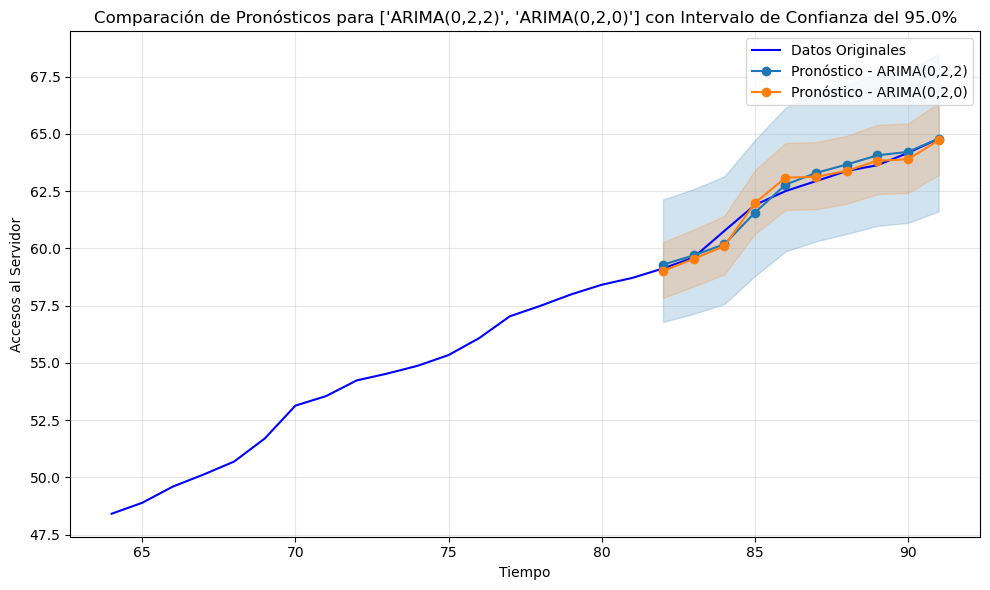

In [15]:
# Definir el número de períodos que deseas pronosticar
num_predictions = 10  # Número de períodos a pronosticar

# Determinar el índice del último dato disponible en la serie temporal
end = len(time_series_df['points']) - 1  # Último índice de los datos disponibles

# Calcular el índice inicial del período a pronosticar
start = end - (num_predictions - 1)  # Comenzar desde los últimos `num_predictions` períodos

# Llamar a la función forecast para realizar los pronósticos
forecast(
    time_series_df['points'],  # Serie temporal original
    models_to_forecast,        # Lista de modelos ARIMA a utilizar para los pronósticos
    start=start,               # Índice inicial del período de pronóstico
    end=end,                   # Índice final del período de pronóstico
    lmbda=lmbda,                # Parámetro de tran
    norm_fac = norm_fac
)

### Predecir los valores fuera de la muestra


Pronóstico para ARIMA(0,2,2) para los próximos 9 períodos con Intervalo de Confianza del 95.0%:
92     65.429773
93     66.091284
94     66.771809
95     67.472261
96     68.193618
97     68.936923
98     69.703294
99     70.493931
100    71.310122
101    72.153250
Name: predicted_mean, dtype: float64

Intervalos de Confianza:
     lower T_points  upper T_points
92        62.169571       69.216901
93        61.415498       71.918747
94        60.846718       74.650947
95        60.340125       77.597520
96        59.849899       80.882476
97        59.354968       84.629688
98        58.845100       88.988462
99        58.315631       94.158066
100       57.765017      100.423603
101       57.193532      108.219013

Comparación del Pronóstico con los Datos Originales:
Fecha		Pronóstico	Datos Originales	Diferencia
0	65.43		30.21		-35.22
1	66.09		30.32		-35.77
2	66.77		30.35		-36.42
3	67.47		30.43		-37.04
4	68.19		30.43		-37.76
5	68.94		30.54		-38.40
6	69.70		30.66		-39.05
7	70.49		30.6

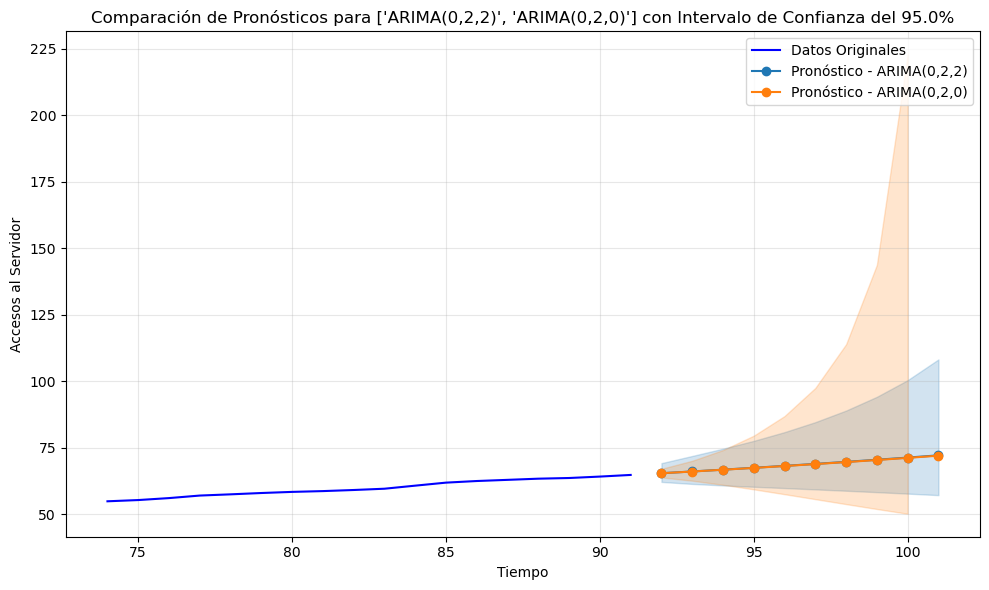

In [16]:
# Definir el número de períodos que deseas pronosticar hacia el futuro
num_predictions = 10  # Número de períodos a pronosticar

# Calcular el índice de inicio y final para los pronósticos futuros
start = len(time_series_df['points'])  # Índice inmediatamente después de los datos disponibles
end = start + num_predictions - 1  # Índice final de los pronósticos (10 períodos hacia el futuro)

# Llamar a la función forecast para realizar los pronósticos
forecast(
    time_series_df['points'],  # Serie temporal original
    models_to_forecast,        # Lista de modelos ARIMA a utilizar para los pronósticos
    start=start,               # Índice inicial del período de pronóstico (futuro)
    end=end,                   # Índice final del período de pronóstico (futuro)
    lmbda=lmbda,                # Parámetro de transformación Box-Cox (si se aplicó previamente)
    norm_fac = norm_fac
)
